# Comprehensive Tutorial: Advanced Radio Mapping with CKMapSolver

This notebook demonstrates the generation of **Channel Knowledge Maps (CKM)** using the customized `Sionna-RT`. 

### Key Metrics to be Extracted:
1. **Temporal**: Path Gain (dB), ToA (ns), RMS-DS (ns).
2. **Directional (DoA/DoD)**: Azimuth, Elevation, and Angular Spread.
3. **Visibility**: Line-of-Sight (LoS) identification.

In [59]:
import sionna.rt as srt
import matplotlib.pyplot as plt
import numpy as np
from utils import get_basic_metrics, get_angular_metrics

# Load a high-fidelity urban scene (e.g., Munich)
scene = srt.load_scene(srt.scene.munich)

# Configure Antenna Array for Directional Metrics
# Essential for DoA/DoD calculations
scene.tx_array = srt.PlanarArray(num_rows=1, num_cols=1, 
                                vertical_spacing=0.5, 
                                pattern="iso", polarization="V")

# Add a Transmitter (TX) in the environment
tx = srt.Transmitter(name="tx", position=[-50, -75, 20])
scene.add(tx)

In [61]:
# Initialize the Enhanced CKMapSolver
rm_solver = srt.CKMapSolver()

# Launch simulation with 10^8 samples for "Gold Standard" accuracy
# This configuration accounts for complex propagation: Specular, Diffuse, and Refraction.
rm = rm_solver(
    scene=scene,
    max_depth=15,
    samples_per_tx=(10**8),
    cell_size=(2.0, 2.0),    
    center=[0.0, 0.0, 1.5],    
    size=[1024, 1024],            
    orientation=[0, 0, 0],
    los=True,
    specular_reflection=True,
    diffuse_reflection=True,
    refraction=False,
    seed=42
)

In [62]:
# 1. Process Basic Metrics (Path Gain, ToA, RMS-DS)
pg_db, toa_ns, ds_ns, is_los = get_basic_metrics(rm)

# 2. Process Direction of Arrival (DoA) Metrics
doa_azi, doa_ele, dsa = get_angular_metrics(rm.mean_doa)

# 3. Process Direction of Departure (DoD) Metrics
dod_azi, dod_ele, dsd = get_angular_metrics(rm.mean_dod)

print("Metric extraction complete. Data ready for visualization.")

Metric extraction complete. Data ready for visualization.


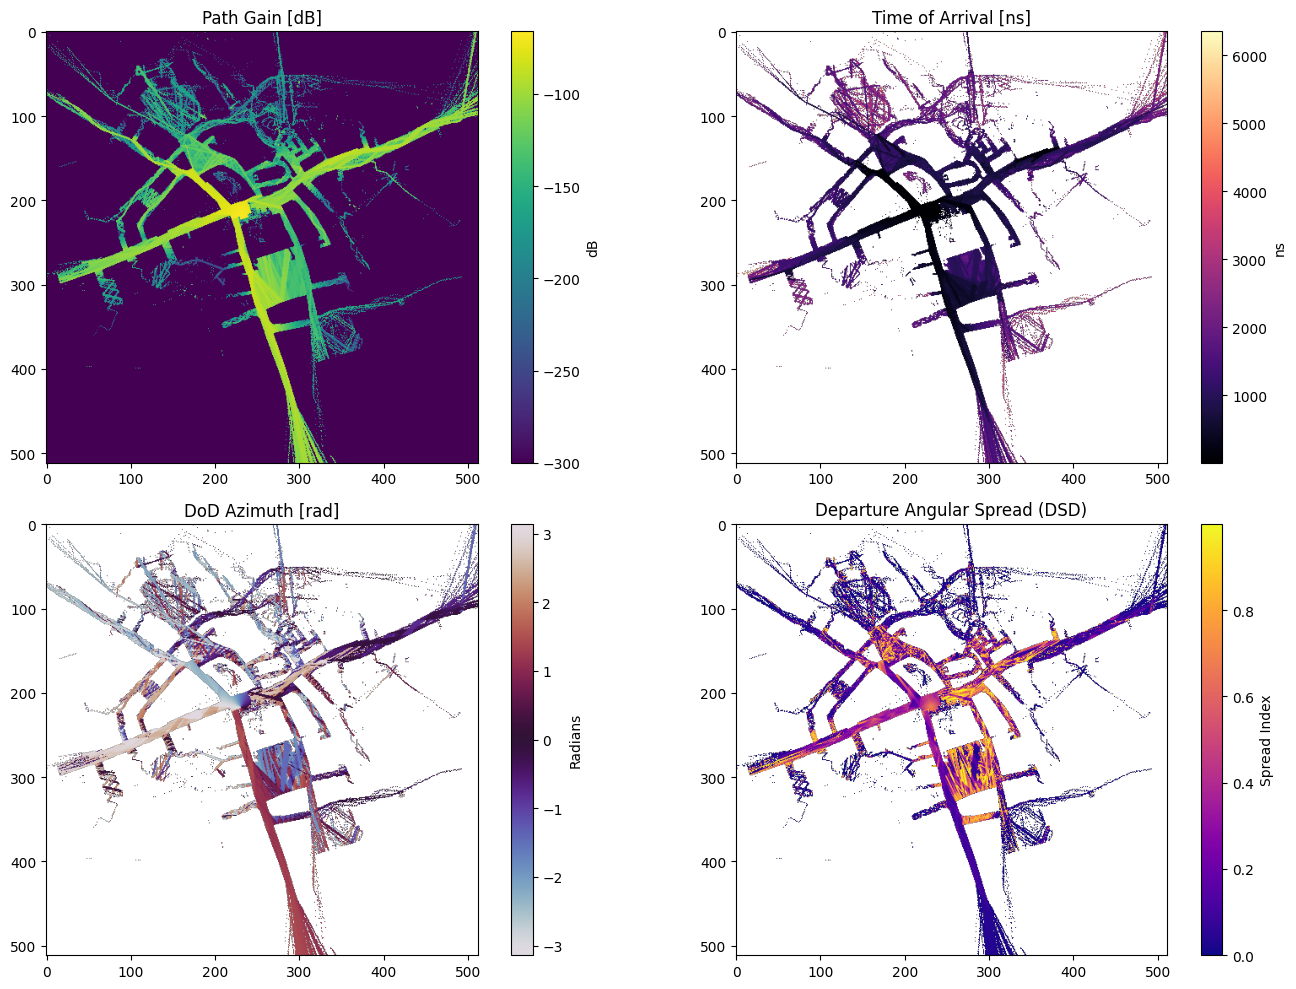

In [63]:
# Generate a comparative showcase plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# [0,0] Path Loss Map
im1 = axes[0,0].imshow(pg_db[0], cmap='viridis')
axes[0,0].set_title("Path Gain [dB]")
plt.colorbar(im1, ax=axes[0,0], label='dB')

# [0,1] Time of Arrival Map
im2 = axes[0,1].imshow(toa_ns[0], cmap='magma')
axes[0,1].set_title("Time of Arrival [ns]")
plt.colorbar(im2, ax=axes[0,1], label='ns')

# [1,0] Direction of Departure Azimuth
im3 = axes[1,0].imshow(dod_azi[0], cmap='twilight')
axes[1,0].set_title("DoD Azimuth [rad]")
plt.colorbar(im3, ax=axes[1,0], label='Radians')

# [1,1] Angular Spread (DSD)
im4 = axes[1,1].imshow(dsd[0], cmap='plasma')
axes[1,1].set_title("Departure Angular Spread (DSD)")
plt.colorbar(im4, ax=axes[1,1], label='Spread Index')

plt.tight_layout()
plt.show()

## Advanced Metrics Extraction and Interactive 3D Visualization

In this final step, we summarize all available metrics and demonstrate the **Interactive 3D Preview**. 
The `CKMap` integrates seamlessly with Sionna's Mitsuba-based renderer, allowing you to inspect multipath effects directly on the 3D scene geometry.

### Available Metrics:
- **Standard**: `path_gain`, `rss`, `sinr`, `rms_ds`, `toa`, `is_los`
- **Directional**: `dsa`, `doa_azi`, `doa_ele` (Arrival) and `dsd`, `dod_azi`, `dod_ele` (Departure)

In [64]:
# --- 1. Comprehensive Metric Extraction ---
# Using the helper functions from utils.py to organize all 12+ parameters

# Standard Metrics
pg_db, toa_ns, ds_ns, is_los = get_basic_metrics(rm)

# Arrival Directional Metrics (DoA)
doa_azi, doa_ele, dsa = get_angular_metrics(rm.mean_doa)

# Departure Directional Metrics (DoD)
dod_azi, dod_ele, dsd = get_angular_metrics(rm.mean_dod)


# --- 2. Interactive 3D Preview ---
# You can change 'rm_metric' to other supported internal buffers like 'path_gain' or 'rms_ds'.
# This opens a 3D window where you can rotate the scene and see the radio map overlaid on buildings.

# Example: Visualizing RMS Delay Spread in 3D
scene.preview(ck_map=rm, rm_metric="rms_ds", rm_tx=0)